In [1]:
from reiddataset import *

In [2]:
data_dir = '/home/linshan/dataset/'
download_dataset('Market1501', data_dir)
download_dataset('DukeMTMC', data_dir)

Dataset Check Success: Market1501 exists!
Dataset Check Success: DukeMTMC exists!


In [3]:
pytorch_prepare_all(data_dir)

Market1501 pytorch directory exists!
DukeMTMC pytorch directory exists!


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import time
import os

In [5]:
transform_train_list = [
        transforms.Resize(144),
        transforms.RandomCrop((256,128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]

transform_val_list = [
        transforms.Resize(size=(256,128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]

In [6]:
data_transforms = {
    'train': transforms.Compose( transform_train_list ),
    'val': transforms.Compose(transform_val_list),
}

In [7]:
dataset_name = 'Market1501'
image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir+'/'+dataset_name+'/pytorch/train'),
                                          data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir+'/'+dataset_name+'/pytorch/val'),
                                          data_transforms['val'])

In [8]:
batch_size = 32
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 12185, 'val': 751}


In [10]:
use_gpu = torch.cuda.is_available()

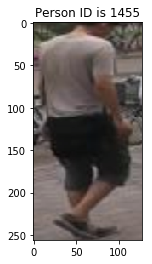

In [11]:
%matplotlib inline
def imshow(images, id, class_names, index):
    images = images[index].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title('Person ID is '+ str(class_names[id[index]]))
    plt.pause(0.001)

index = 31
images, id = next(iter(dataloaders['train']))
class_names = image_datasets['train'].classes
imshow(images,id,class_names, 31)

In [12]:
loss = {}
loss['train'] = []
loss['val'] = []
error = {}
error['train'] = []
error['val'] = []

In [23]:
def save_network(network, epoch_label):
    save_filename = 'net_%s.pth'% epoch_label
    save_dir = './model'
    if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    save_path = os.path.join(save_dir, save_filename)
    torch.save(network.cuda().state_dict(), save_path)

In [24]:
def train(model, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                images, id = data
                
                images = Variable(images.cuda())
                id = Variable(id.cuda())
                
                optimizer.zero_grad()
                
                outputs = model(images)
                _, preds = torch.max(outputs.data,1)
                loss = criterion(outputs, id)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == id.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                if (epoch+1)%10 == 0:
                    save_network(model, epoch+1)

In [25]:
from model import ft_net
model = ft_net(len(class_names))
model = model.cuda()
#print(models)

In [26]:
criterion = nn.CrossEntropyLoss()

In [27]:
optimizer_ft = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=5e-4, nesterov=True)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=40, gamma=0.1)

In [28]:
model = train(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)

Epoch 1/60
----------
train Loss: 0.1542 Acc: 0.1645
val Loss: 0.1288 Acc: 0.2650
Epoch 2/60
----------
train Loss: 0.0747 Acc: 0.5165
val Loss: 0.0780 Acc: 0.4767
Epoch 3/60
----------
train Loss: 0.0422 Acc: 0.7055
val Loss: 0.0493 Acc: 0.6498
Epoch 4/60
----------
train Loss: 0.0269 Acc: 0.8130
val Loss: 0.0416 Acc: 0.7150
Epoch 5/60
----------
train Loss: 0.0188 Acc: 0.8637
val Loss: 0.0265 Acc: 0.8056
Epoch 6/60
----------
train Loss: 0.0139 Acc: 0.9028
val Loss: 0.0222 Acc: 0.8389
Epoch 7/60
----------
train Loss: 0.0112 Acc: 0.9243
val Loss: 0.0210 Acc: 0.8535
Epoch 8/60
----------
train Loss: 0.0086 Acc: 0.9412
val Loss: 0.0153 Acc: 0.8828
Epoch 9/60
----------
train Loss: 0.0074 Acc: 0.9505
val Loss: 0.0159 Acc: 0.8868
Epoch 10/60
----------
train Loss: 0.0061 Acc: 0.9614
val Loss: 0.0150 Acc: 0.8921
Epoch 11/60
----------
train Loss: 0.0047 Acc: 0.9742
val Loss: 0.0144 Acc: 0.8921
Epoch 12/60
----------
train Loss: 0.0041 Acc: 0.9779
val Loss: 0.0115 Acc: 0.9081
Epoch 13/60
-